# Bayesian Generalized Linear Models in PyMC3

# Introduction

There are a number of packages in the Python ecosystem that are used heavily in statistical modeling. We will make use of several of them (`NumPy`, `pandas`) throughout the course of this chapter, but our main focus here is Bayesian modeling. Specifically we will be focusing on modifying several of our standard statistical methodologies to function within a Bayesian framework. We will discuss why a Bayesian approach is a reasonable one to take and show examples of Generalized Linear Model (GLM) implementation in PyMC3, a probabilistic programming package for defining intuitive hierarchical models. We start with a basic Bayesian linear regression model, explaining the theory, and build up into a hierarchical linear regression model.

## Generalized Linear Models (GLM)

A Generalized Linear Model (GLM) is a blanket term for many of our standard linear models in statistics. This generalization allows for the assignment of arbitrary distributions to response variables, encompassing both linear and logistic regression, and allows us to create Bayesian implementations of these classical ideas. We can assign random variables to parameters and outcomes of these more general model forms, quantifying the uncertainty in terms of probabilities.

## Probabilistic Programming and Bayes' Rule

In probabilistic programming, we define the components of our model as random variables. We apply Bayes' rule to adapt our initial model, incorporating observed data to build a new model to infer unknown causes. Bayes' rule is defined as follows:

$$ P(\theta\ |\ \mathbf{X}, \alpha) = \frac{P(\mathbf{X}\ |\ \theta)\  P(\theta,\alpha)}{P(\mathbf{X}, \alpha)} \propto P(\mathbf{X}\ |\ \theta)\  P(\theta, \alpha) $$

Bayes' rule allows us to construct a posterior distribution ($P(\theta\ |\ \mathbf{X}, \alpha)$) based on our likelihood ($P(\mathbf{X}\ |\ \theta)$) and prior distribution ($P(\theta, \alpha)$), where $\theta$ is a set of the parameters we have defined for the model with $\alpha$ as the set of parameters for those parameters and $\mathbf{X}$ is a set of our observations. We don't need to worry about $P(\mathbf{X}, \alpha)$ for our purposes as it serves primarily as a normalization factor.

Calculating the posterior distribution directly can be complicated, especially with more complex models that incorporate a lot of hierarchical structure, but we fortunately do not have to deal with that. With probabilistic programming, we define our priors and our likelihood and let a combination of sampling algorithms approximate the posterior! Let's modify our definition of linear regression to incorporate these principles.

## Linear Regression

The first GLM that we will cover is linear regression. Linear regression is a standard quantitative tool in every statistician's toolbox. It provides a simple, easy-to-understand framework for expressing a linear relationship between dependent and independent variables and can be readily applied in many situations. A standard linear regression takes the form of:

$$ Y = X\beta + \epsilon $$

Where $Y$ is the dependent variable, $X$ is our independent variable, $\beta$ are the coefficients for each feature in $X$, and $\epsilon$ is our error, assumed to be normally-distributed.

There are several ways to fit the coefficients. We typically use either Ordinary Least Squares (OLS) or Maximum Likelihood Estimation (MLE).

## Probabilistic Regression

To reformulate this linear regression with a Bayesian methodology, we say that:

$$ Y \sim \mathcal{N}(X\beta, \sigma^2) $$

In other words, we assume that our response variable will follow a normal distribution with mean $X\beta$ and variance $\sigma^2$. With Bayesian inference, the key component is that we define the pieces of our model as probability distributions. The above is the basic formulation of the model, but *everything* is a probability distribution. All of the parameters of our model will have prior distributions associated with them so we need a way to easily define random variables. This is where we apply PyMC3 and the principles of probabilistic programming.

## PyMC3

All of our examples in this chapter will showcase the use of PyMC3 to formulate models in the aforementioned way. PyMC3 is an open source probabilistic programming framework that allows us to define entire Bayesian models using Python code. It uses Monte Carlo and variational methods to compute results with `Theano` as a backend.

## Advantages of the Bayesian Approach

At their cores, both the frequentist and Bayesian approaches try to get at the same solution. They only differ in how they go about it. By incorporating Bayesian statistics into our methodology, we allow for the inclusion of prior distributions. Priors allow us to include our own views about our parameters into the model. 

In addition, the $\beta$ "values" that we calculate through this Bayesian approach are themselves complete posterior distributions instead of point estimates (hence the scare-quotes). A point estimate will have a confidence interval, but a posterior distribution provides us with a much more robust understanding of the uncertainty. Quantifying uncertainty as probability is cornerstone of Bayesian inference.

## Defining a Toy Example

Let's generate some simple data for use with our new approach. Toy examples are always a little boring, but it is important to understand the basic approach before we get into a real world problem.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pymc3 as pm
import theano.tensor as tt

In [2]:
sns.set_style('whitegrid')
%matplotlib inline

In [3]:
N = 100
intercept = 1
slope = 2

x = np.random.normal(0, 1, N)
true_line = intercept + slope*x
y = true_line + np.random.normal(0, 0.5, size=N)

data = dict(x=x, y=y)

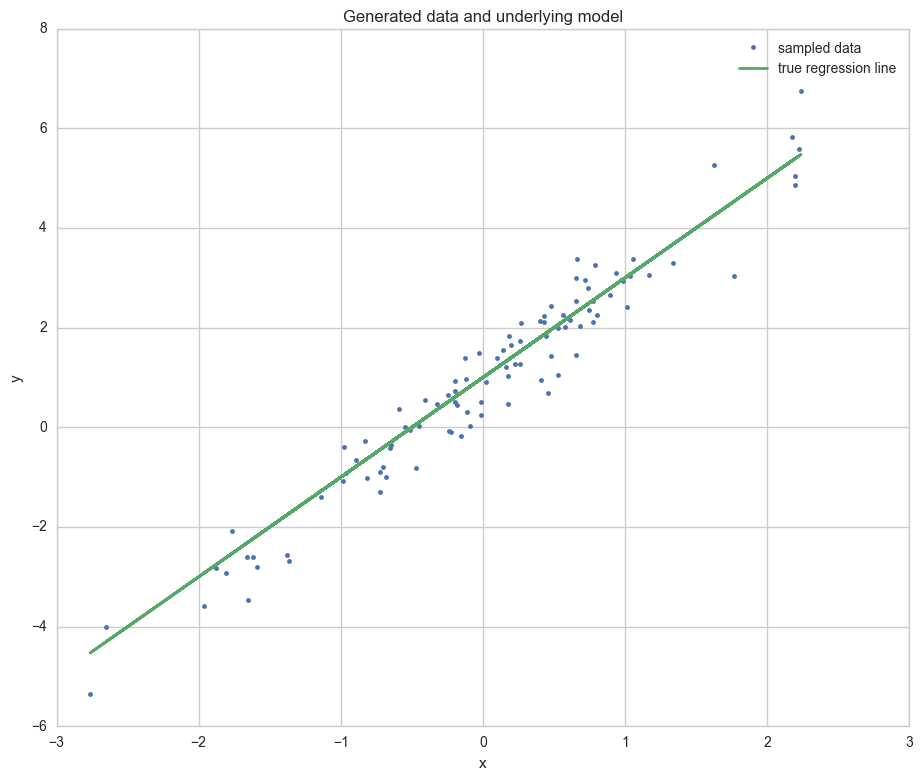

In [4]:
fig = plt.figure(figsize=(11, 9))
ax = fig.add_subplot(111, xlabel='x', ylabel='y', title='Generated data and underlying model')
ax.plot(x, y, '.', label='sampled data')
ax.plot(x, true_line, label='true regression line', lw=2.)
plt.legend(loc=0);

The data points in this scatter plot are our observed information about the true relationship between $x$ and $y$. This observed information contorts our initial impressions of how our parameters are distributed into our posterior distributions.

## Creating Our Model

Let's define our priors for the Bayesian model. With PyMC3, it is remarkably easy to lay out which components of the model will follow which distributions, however, this may be confusing if you are unfamiliar with the Bayesian framework. The typical model definition is laid out here. In PyMC3, we define all of our variables using the `with` context.

In [5]:
with pm.Model() as toy_model:
    # Defining priors
    sigma = pm.HalfCauchy('sigma', beta=10, testval=1.0)
    intercept = pm.Normal('Intercept', mu=0, sd=20)
    x_beta = pm.Normal('x', mu=0, sd=20)
    
    # Defining likelihood
    likelihood = pm.Normal('y', mu=(intercept + x_beta * x), sd=sigma, observed=y)
    
    # Running Inference
    toy_trace = pm.sample(2000) # Draw 2000 samples!

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -91.323: 100%|██████████| 200000/200000 [00:28<00:00, 6976.51it/s]
Finished [100%]: Average ELBO = -91.311
100%|██████████| 2000/2000 [00:04<00:00, 476.02it/s]


If you are less familiar with probabilistic programming, this may look like a lot of nonsense. The syntax for defining probability distributions is intuitive, but this is a lot of extra buzz around the implementation of a basic linear regression. 

For this reason, the PyMC3 developers introduced a `glm` module to simplify the definition of Generalized Linear Models (GLM), including linear regressions such as ours.

In [6]:
with pm.Model() as toy_model:
    pm.glm.glm('y ~ x', data)
    toy_trace = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -112.96: 100%|██████████| 200000/200000 [00:28<00:00, 6927.85it/s]
Finished [100%]: Average ELBO = -112.95
100%|██████████| 2000/2000 [00:04<00:00, 449.15it/s]


## Basic Diagnostics

We have a few things to examine after fitting a Bayesian model. Here are the plots that show our posterior distributions as well as our traceplots: 

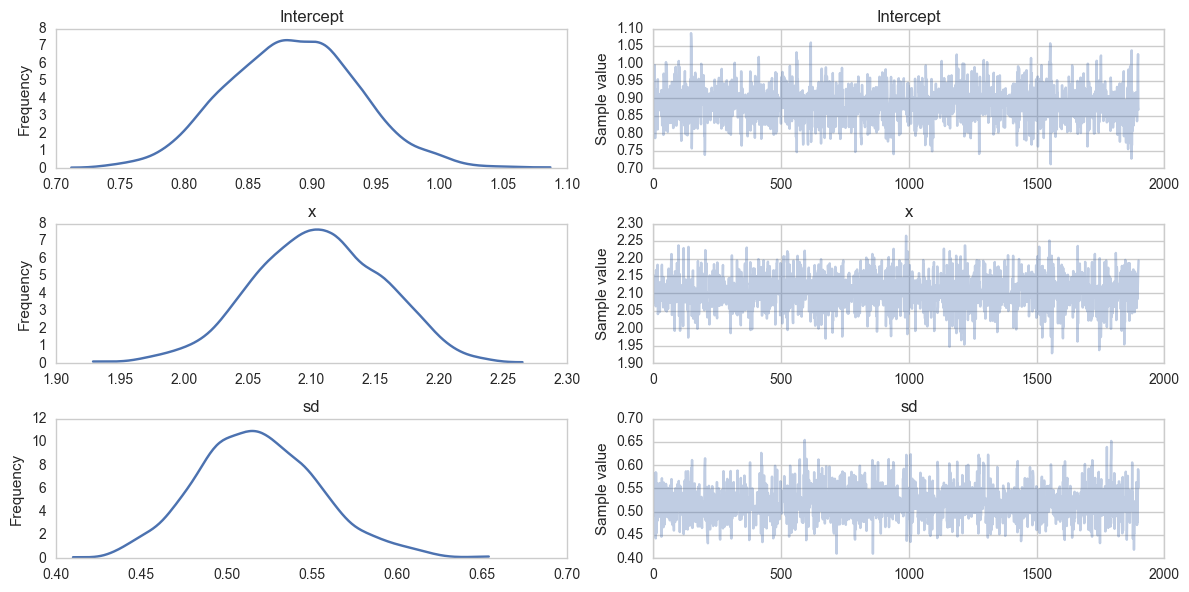

In [7]:
plt.figure(figsize=(11, 9))
pm.traceplot(toy_trace[100:])
plt.tight_layout();

The posterior distributions on the left show how the various components of our regression are distributed after incorporating the observed data.

The traceplots on the right show us whether our traces have converged. The trace is the set of samples from the posterior distribution generated by the sampler. The risk with our sampling methods is that we may end up with a bunch of junk values before we have proper samples of the posterior distribution. This is why we only looked at samples *after* the first one hundred, in this case. This is called a **burn-in period**. A non-stationary trace indicates that we need a longer burn-in period.

What's nice here is that the means of our posterior distributions are fairly close to the values that we used to generate the data.

In [8]:
print('-------Means-------')
print('Intercept: ', toy_trace[100:]['Intercept'].mean())
print('x_beta: ', toy_trace[100:]['x'].mean())
print('sd: ', toy_trace[100:]['sd'].mean())

-------Means-------
Intercept:  0.885138920246
x_beta:  2.10516893107
sd:  0.518335396681


In addition to looking at the posterior distributions of our paramaeters, we can also examine the highest posterior density (HPD) interval of each parameter. The HPD is a type of **credible interval**, a Bayesian interval estimate. Credible intervals are not unique, however. As long as a parameter has a probability of $0.95$ to lie within a particular interval, that interval is a $95\%$ credible interval for that parameter. Here we specifically want to look at the $95\%$ HPD interval. This is the narrowest credible interval and it tends to contain the values that have the highest probability density. There are other informative credible intervals, such as the **equal-tailed interval**, where the probability of being below the interval is equal to the probability of being above it, but we only look at the HPD here.

In [9]:
HPD = pm.stats.hpd(toy_trace)
for key, value in HPD.items():
    print(key, " HPD: ", "({0}, {1})".format(value[0], value[1]))

sd_log_  HPD:  (-0.8025994730758856, -0.526504194571248)
sd  HPD:  (0.44557591919879597, 0.5875754276541328)
Intercept  HPD:  (0.7843183715625596, 0.9852245290551088)
x  HPD:  (2.008960742384813, 2.202475881224824)


Finally, let's have a look at our response variable. Instead of drawing a single line as with the frequentist approach, here we have a distribution of regression lines. We plot our possibilities by examining the posterior predictive distribution. This entails sampling from our calculated posteriors and drawing regression lines using this new set of samples.

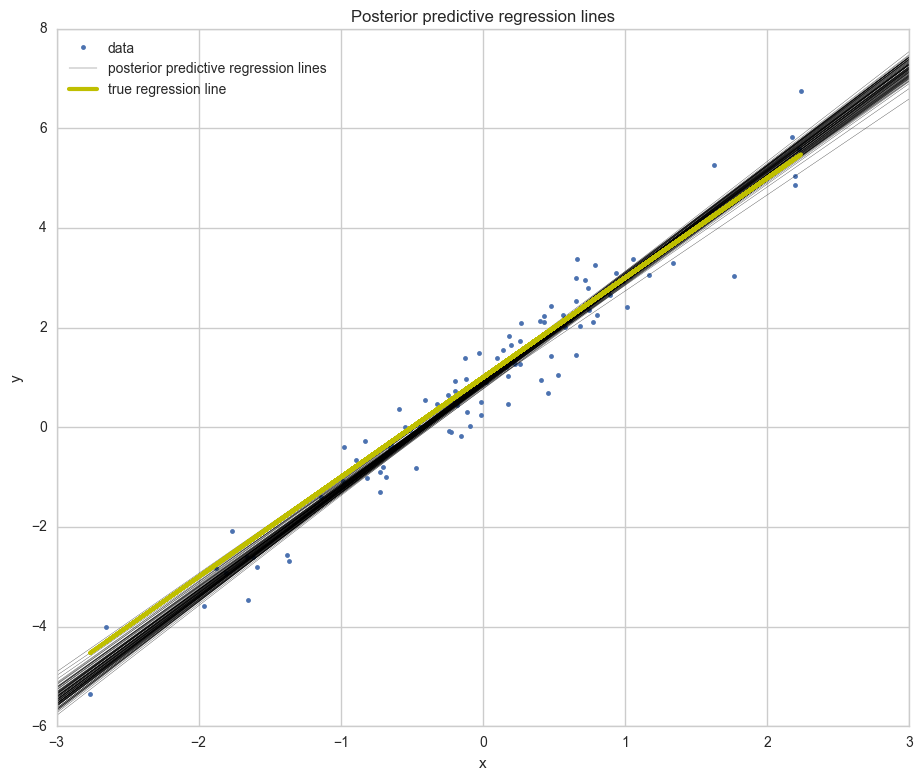

In [10]:
plt.figure(figsize=(11, 9))
plt.plot(x, y, '.', label='data')
pm.glm.plot_posterior_predictive(
    toy_trace,
    samples=100,
    eval=np.linspace(-3, 3, 100),
    label='posterior predictive regression lines'
)
plt.plot(x, true_line, label='true regression line', lw=3., c='y')

plt.title('Posterior predictive regression lines')
plt.legend(loc=0)
plt.xlabel('x')
plt.ylabel('y');

The variation of the lines here (our distribution) give us a measure of uncertainty. By sampling from the posterior distribution, we can define our uncertainty in terms of a probability distribution (or the samples of a probabilitity distribution), the key idea behind Bayesian inference!

## Logistic Regression

The next GLM we will cover is logistic regression. Extending logistic regression to work within a Bayesian framework is again simple in PyMC3. Logistic regression is a fan favorite method for classification and is applied in many different situations. It is easy to understand, like linear regression, which is likely a large part of its longetivity in the face of so many powerful machine learning classifiers. Our typical logistic regression looks like this:

$$ F(x) = \frac{1}{1 + e^{X\beta + \epsilon}} $$

Essentially, we take a linear regression and squash it into a logistic function. When we make it Bayesian, we say that:

$$ F \sim \text{Bernoulli}(p),\ \ p = \frac{1}{1 + e^{Y}},\ \ Y \sim \mathcal{N}(X\beta, \sigma^2)$$

We model the outcome as a Bernoulli random variable because this is a classification problem. Bernoulli random variables are binary, taking on a value of $1$ with probability $p$ and taking on a value of $0$ with probability $(1-p)$. The logistic function will output the probability of our model taking on a value of $1$ and we truncate this to either $1$ or $0$ for classification. As with the above linear regression, we can  create a Bayesian logistic regression in PyMC3 using the `glm` module.

### Predicting Credit Card Defaults

A common thing to attempt to predict is the probability of credit card default. The binary outcome of "default or not" lends itself intuitively to a binary classification problem. 

We will use the "Default of Credit Card Clients" data set from the UC Irvine Machine Learning Repository [1] here to develop a logistic model. We pull in the data with `pandas`.

In [11]:
data = pd.read_excel(
    "http://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls",
    header=1,
    index_col=0)

In [12]:
data.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
ID,,,,,,,,,,,,,,,,,,,,,
1,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


For the sake of simplicity, we will drop most of the attributes here so that we only have some basic features to include in our model. The attribute `BILL_AMT1` contains the credit card bill amount for each individual client in September 2005 and the `PAY_AMT1` variable contains the amount that was paid in September 2005. `EDUCATION` and `MARRIAGE` are each categorical variables that indicate the education level and marital status of each client with an integer code, detailed here:

* EDUCATION: (1 = graduate school; 2 = university; 3 = high school; 4 = others)
* MARRIAGE: (1 = married; 2 = single; 3 = others)

We store whether the client defaulted on a payment as well for our response variable.

In [13]:
default = data['default payment next month']
data = data[['EDUCATION', 'MARRIAGE', 'BILL_AMT1', 'PAY_AMT1']]
data['default'] = default
data = data.dropna()

In [14]:
data.head()

,EDUCATION,MARRIAGE,BILL_AMT1,PAY_AMT1,default
ID,,,,,
1,2,1,3913,0,1
2,2,2,2682,0,1
3,2,2,29239,1518,0
4,2,1,46990,2000,0
5,2,1,8617,2000,0


Here we define the model and sample:

In [15]:
with pm.Model() as logistic_model:
    pm.glm.glm('default ~ EDUCATION + MARRIAGE + BILL_AMT1 + PAY_AMT1', data, family=pm.glm.families.Binomial())
    logistic_trace = pm.sample(3000, tune=100)[100:]

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -98,989: 100%|██████████| 200000/200000 [09:57<00:00, 334.49it/s]    
Finished [100%]: Average ELBO = -98,990
100%|██████████| 3000/3000 [29:40<00:00,  2.22it/s] 


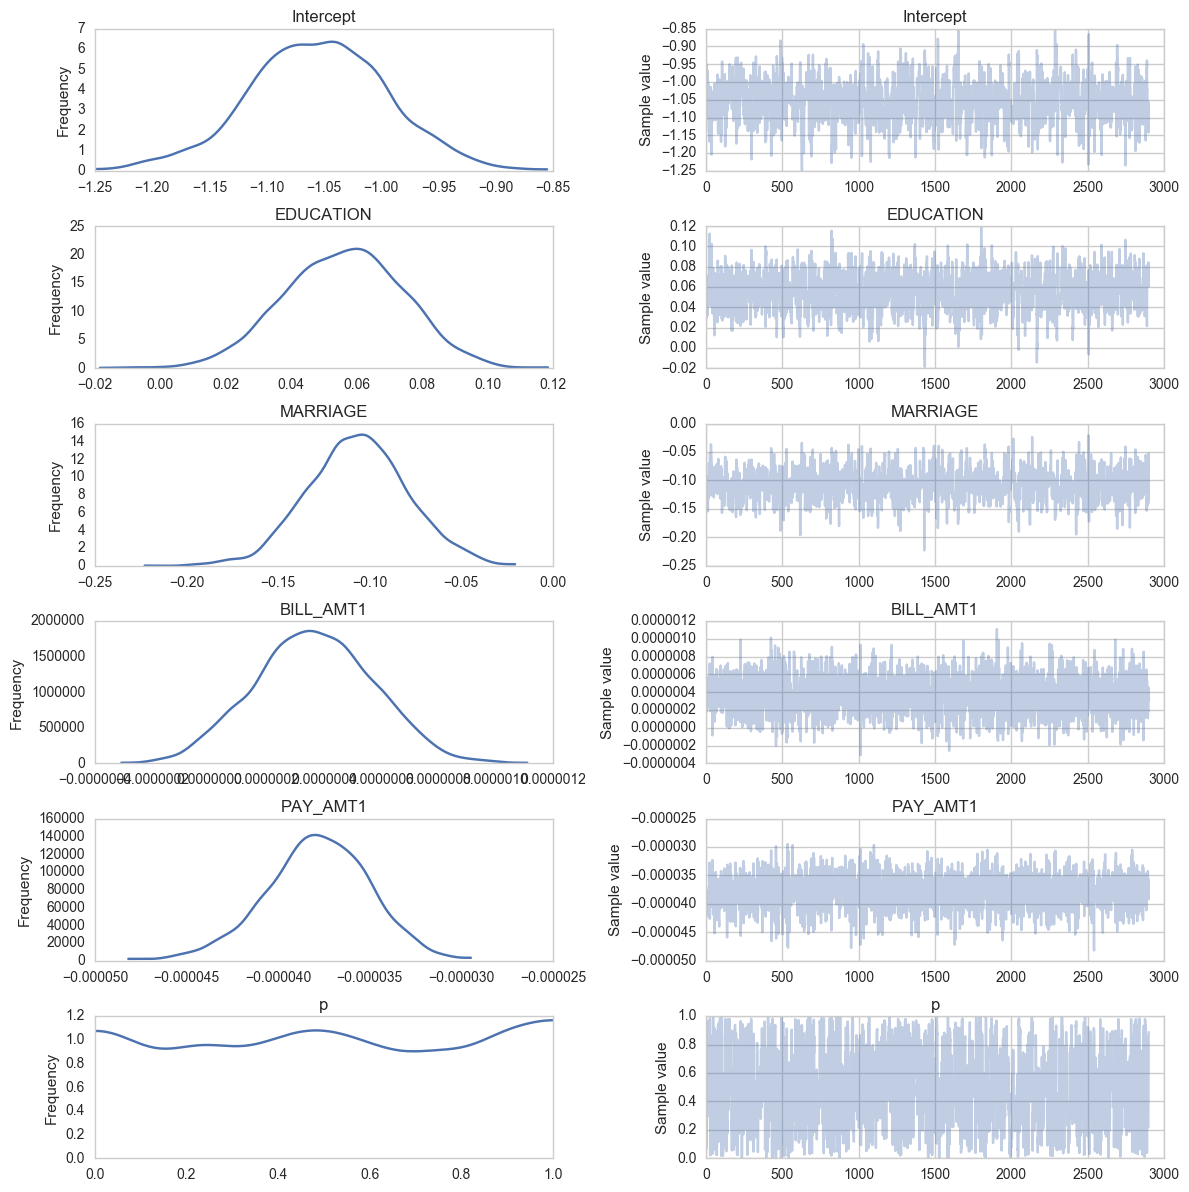

In [16]:
pm.traceplot(logistic_trace);

To generate predictions using our model, we will sample from the posterior distribution. We define some particular instances of our model using lambda functions. We vary the September bill amount of our theoretical clients to see what the default curve would look like for someone who is single, paid $1000 on their September bill, and is of a given education level (which we change for each instance to compare). We want to look at how education and bill amount relate to the probability of default.

In [17]:
lm = lambda x, samples: 1 / (1 + np.exp(-(samples['Intercept'] +
                                          samples['EDUCATION']*1 + 
                                          samples['MARRIAGE']*2 +
                                          samples['BILL_AMT1']*x +
                                          samples['PAY_AMT1']*1000
                                          )))
lm2 = lambda x, samples: 1 / (1 + np.exp(-(samples['Intercept'] +
                                          samples['EDUCATION']*2 + 
                                          samples['MARRIAGE']*2 +
                                          samples['BILL_AMT1']*x +
                                          samples['PAY_AMT1']*1000
                                          )))
lm3 = lambda x, samples: 1 / (1 + np.exp(-(samples['Intercept'] +
                                          samples['EDUCATION']*3 + 
                                          samples['MARRIAGE']*2 +
                                          samples['BILL_AMT1']*x +
                                          samples['PAY_AMT1']*1000
                                          )))

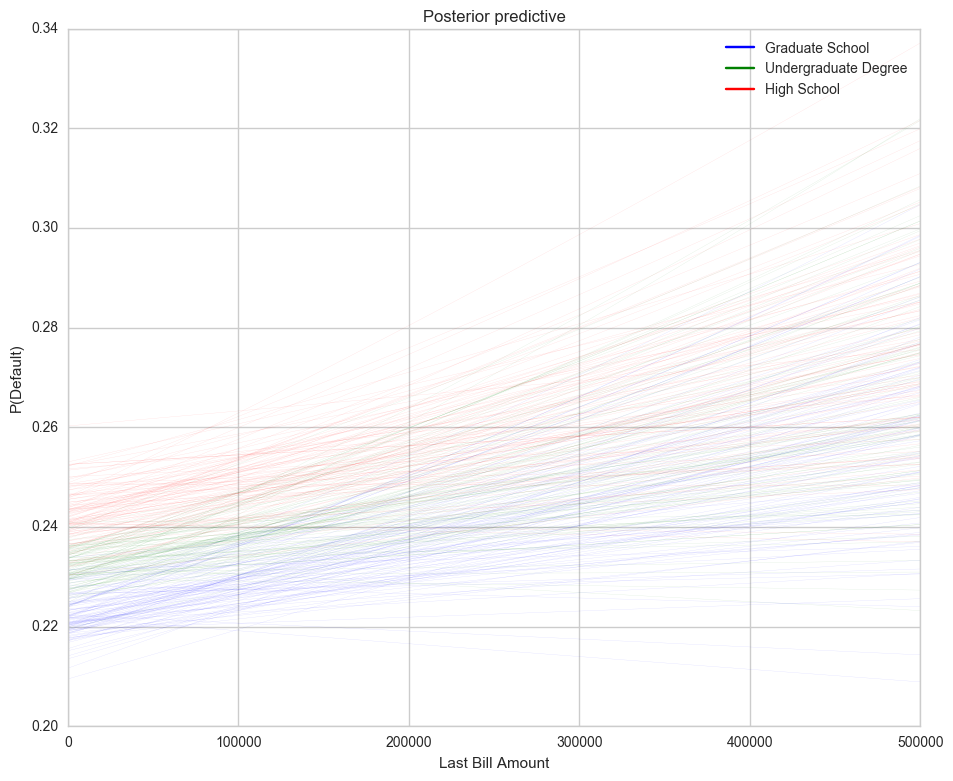

In [18]:
plt.figure(figsize=(11, 9))
pm.glm.plot_posterior_predictive(
    logistic_trace,
    eval=np.linspace(0, 500000, 10000),
    lm=lm,
    samples=100,
    color='b',
    alpha=0.15
)
pm.glm.plot_posterior_predictive(
    logistic_trace,
    eval=np.linspace(0, 500000, 10000),
    lm=lm2, samples=100,
    color='g',
    alpha=0.15
)
pm.glm.plot_posterior_predictive(
    logistic_trace,
    eval=np.linspace(0, 500000, 10000),
    lm=lm3,
    samples=100,
    color='r',
    alpha=0.15
)
import matplotlib.lines as lines
blue_line = lines.Line2D(['lm'], [], color='b', label='Graduate School')
green_line = lines.Line2D(['lm2'], [], color='g', label='Undergraduate Degree')
red_line = lines.Line2D(['lm3'], [], color='r', label='High School')

plt.legend(handles=[blue_line, green_line, red_line], loc='upper right')
plt.ylabel("P(Default)")
plt.xlabel("Last Bill Amount")
plt.show()

Each color here corresponds to the predicted probability of default for a given education level. This seems to imply that those with lower education levels will be more likely to default than those with higher education levels, but there is significantly more uncertainty for all education levels as the bill amount gets higher, resulting in a lot of overlap.

A fun part of logistic regression is that if we exponentiate the coefficient of a feature, we get its odds ratio. The odds ratio indicates whether there is an association between an increase in the given feature and an increase in the outcome probability. We look at the odds ratio of the bill amount to see how increases in the bill amount affect the probability of default.

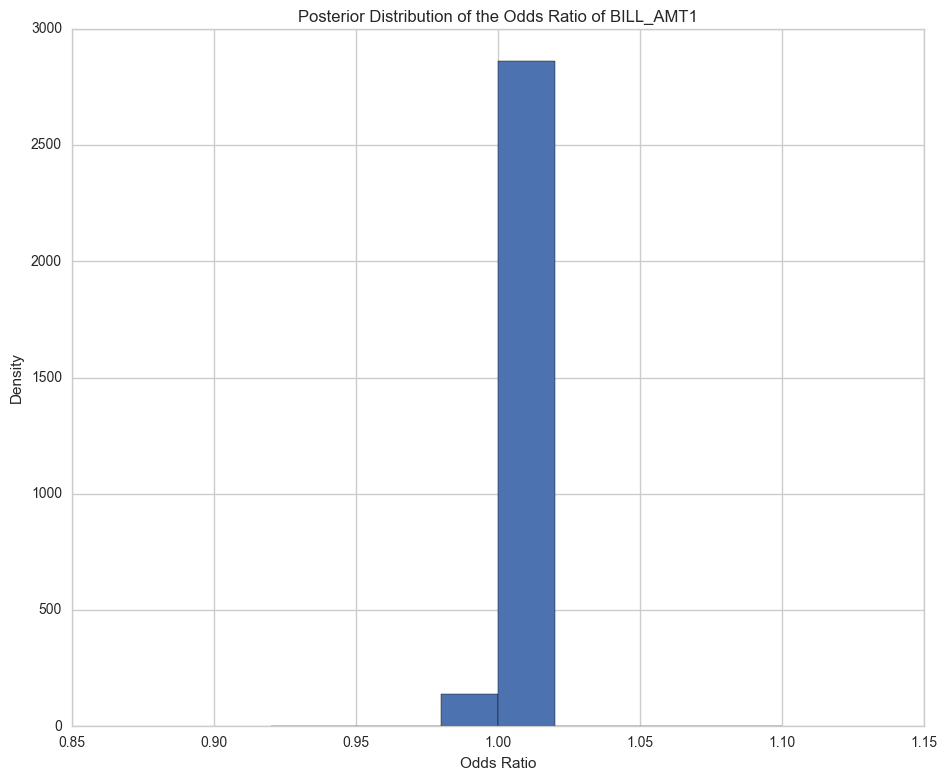

In [19]:
bill_odds = np.exp(logistic_trace['BILL_AMT1'])
plt.figure(figsize=(11, 9))
plt.hist(bill_odds, range=[0.9, 1.1])
plt.title('Posterior Distribution of the Odds Ratio of BILL_AMT1')
plt.xlabel('Odds Ratio')
plt.ylabel('Density');

In [20]:
print('Probability that the Odds ratio is greater than 1:',  (bill_odds > 1).mean())

Probability that the Odds ratio is greater than 1: 0.954


In our case, we exponentiate the posterior distribution of the coefficient, giving us a posterior distribution of the odds ratio. We can see here that the majority of the mass is greater than $1$, so there we can reliably say that, given our model, an increase in the bill amount increases the risk of default.

# Hierarchical Regression

Bayesian modeling lends itself easily to hierarchical structure. We can relate lower-level aspects of the model by establishing relationships between prior distributions. If we hypothesize that several parameters are related, we can connect them by relating their distributions and linking their hyperparameters.

Let's explore how we could handle a dataset with multiple related components using a practical example. In the stock market, everything exists under the same umbrella, that of the market. A classic risk factor to compute for a given portfolio is directly related to this pervasive influence. In specific, this risk factor is defined as the exposure of the returns of our portfolio to the returns of the market. The market can be a powerful positive force in any strategy, but it can also be a very powerful negative force. We want to be able to accurately account for this exposure to make sure that we are appropriately managing the risk exposure of our portfolio. The classical formulation of the model is called the Capital Assets Pricing Model, the CAPM.If we can come up with a reasonable estimate of the influence of the market on a given portfolio, we can take steps to counteract it.

An easy way to compute this exposure is to use a linear regression:

$$ R_P = \alpha + \beta_M * R_M + \epsilon $$

Where $R_P$ is the return of your portfolio, $R_M$ is the returns of the market, $\alpha$ is the intercept term, and $\epsilon$ is a standard normal error. We want to come up with an estimate, $\hat{\beta}_M$, of the influence of the market on the returns of our chosen security or portfolio of securities. To represent the returns of the market, we will use the returns of SPY, an exchange-traded fund that tracks the S&P 500 Index. By expressing the returns of our portfolio like this, we can calculate how much of our portfolio return is actually the market. 

Here we pull the pricing data of a few technology stocks and SPY and put it into the format we want for PyMC3:

In [21]:
import datetime
import pandas_datareader.data as web
import pandas as pd
import numpy as np
import pymc3 as pm

# Name the stocks we want
stocks = ['GOOG', 'TSLA', 'AAPL', 'AMZN', 'FB']
n_securities = len(stocks)
# Define start and end dates
start_date = "2014-01-01"
end_date = "2015-01-01"
# Name our benchmark and get its returns
spy = web.DataReader('SPY', 'yahoo', start_date, end_date)['Close']
spy = spy.pct_change()[1:]
spy.name = 'SPY'

# Acquire data
returns = pd.DataFrame()
i = 0
for elt in stocks:
    x = web.DataReader(elt, 'yahoo', start_date, end_date)['Close']
    x = x.pct_change()[1:]
    x.name = "Returns"
    symbol = pd.Series(index=x.index, data=elt)
    symbol.name = "Symbol"
    symbol_code = pd.Series(index=x.index, data=i)
    symbol_code.name = "Symbol_Code"
    i+=1
    current_returns = pd.concat([symbol, x, spy, symbol_code], axis=1)
    returns = pd.concat([returns, current_returns])

# Create a dummy variable for each stock symbol
stock_idx = returns.Symbol_Code.values

And this is what our returns data looks like:

In [22]:
returns.groupby('Symbol').head(2)

,Symbol,Returns,SPY,Symbol_Code
Date,,,,
2014-01-03,GOOG,-0.007295,-0.000164,0
2014-01-06,GOOG,0.011149,-0.002898,0
2014-01-03,TSLA,-0.003598,-0.000164,1
2014-01-06,TSLA,-0.017117,-0.002898,1
2014-01-03,AAPL,-0.021966,-0.000164,2
2014-01-06,AAPL,0.005453,-0.002898,2
2014-01-03,AMZN,-0.003845,-0.000164,3
2014-01-06,AMZN,-0.007088,-0.002898,3
2014-01-03,FB,-0.002742,-0.000164,4


We want to calculate the exposure to the market for each of these individual stocks. Now that we have our data, we have a few different options for constructing our model.

## No Hierarchical Structure

We can treat each security in our list as an entity totally independent of the others. With this approach, we will calculate a separate $\hat{\beta}_{M,i}$ for each security in our universe. Essentially, with $N$ securities we have:

\begin{eqnarray*}
R_{S_1} &=& \alpha_1 + \beta_{M,1} * R_M + \epsilon_1\\ 
R_{S_2} &=& \alpha_2 + \beta_{M,2} * R_M + \epsilon_2\\
        &\vdots& \\
R_{S_N} &=& \alpha_N + \beta_{M,N} * R_M + \epsilon_N       
\end{eqnarray*}

This is a common approach and is akin to simply repeating our Bayesian linear regression from above $N$ times. Because we are making several separate models, we will look at the Gelman-Rubin diagnostic to check for convergence instead of checking visually. We construct several discrete sampling chains at the same time (by setting `njobs=4` in the sampler) and the Gelman-Rubin diagnostic tells us whether our values have converged. 

In [23]:
indiv_traces = {}
for symbol in stocks:
    # Select subset of data belonging to county
    s_data = returns.ix[returns.Symbol == symbol]
    s_spy = s_data.SPY
    
    with pm.Model() as individual:
        # Intercept prior (variance == sd**2)
        a = pm.Normal('alpha', mu=0, sd=100**2)
        # Slope prior
        b = pm.Normal('beta', mu=0, sd=100**2)
    
        # Model error prior
        e = pm.Uniform('epsilon', lower=0, upper=10)
    
        # Data likelihood
        exposure_likelihood = pm.Normal('exposure_likelihood',
                                        mu=(a + b * s_spy),
                                        sd=e,
                                        observed=s_data.Returns.values)

        # Inference button (TM)!
        unpooled_trace = pm.sample(5000, njobs=4, tune=500)[500:]
    
    # keep trace for later analysis
    indiv_traces[symbol] = unpooled_trace

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = 465.06: 100%|██████████| 200000/200000 [00:15<00:00, 12926.59it/s]
Finished [100%]: Average ELBO = 465.07
100%|██████████| 5000/5000 [00:13<00:00, 540.19it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = 515: 100%|██████████| 200000/200000 [00:14<00:00, 13370.92it/s]   
Finished [100%]: Average ELBO = 514.98
100%|██████████| 5000/5000 [00:13<00:00, 359.68it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = 338.15: 100%|██████████| 200000/200000 [00:14<00:00, 13385.34it/s]
Finished [100%]: Average ELBO = 338.15
100%|██████████| 5000/5000 [00:14<00:00, 345.62it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = 624.48: 100%|██████████| 200000/200000 [00:14<00:00, 13883.34it/s]
Finished [100%]: Average ELBO = 624.49
100%|██████████| 5000/5000 [00:14<00:00, 347.22it/s]
Auto-assigning NUTS sampler...
Initializing NUTS usi

Now we examine our Gelman-Rubin diagnostics:

In [24]:
for symbol in indiv_traces:
    print('Diagnostics for ', symbol, ' ', pm.diagnostics.gelman_rubin(indiv_traces[symbol]))

Diagnostics for  TSLA   {'alpha': 1.0000407581477422, 'epsilon_interval_': 0.99993434644303747, 'beta': 0.99996533827899081, 'epsilon': 0.99993207684493868}
Diagnostics for  GOOG   {'alpha': 0.99992909038279787, 'epsilon_interval_': 0.99998282886420053, 'beta': 1.0001843940376798, 'epsilon': 0.99998622890586009}
Diagnostics for  AMZN   {'alpha': 1.000016166687522, 'epsilon_interval_': 1.0000138661511466, 'beta': 0.99994323437403687, 'epsilon': 1.0000277009595764}
Diagnostics for  AAPL   {'alpha': 0.99995126322241834, 'epsilon_interval_': 1.0002595237207097, 'beta': 1.0000722687205887, 'epsilon': 1.0002433295535345}
Diagnostics for  FB   {'alpha': 0.99993851295450209, 'epsilon_interval_': 0.99998801711002294, 'beta': 0.99998055121369267, 'epsilon': 0.99998274077325722}


The values of our diagnostic for all of our parameters are close to $1$ so it is safe to say that our values have converged. We can therefore look at our trace to see the posterior distributions of our market betas.

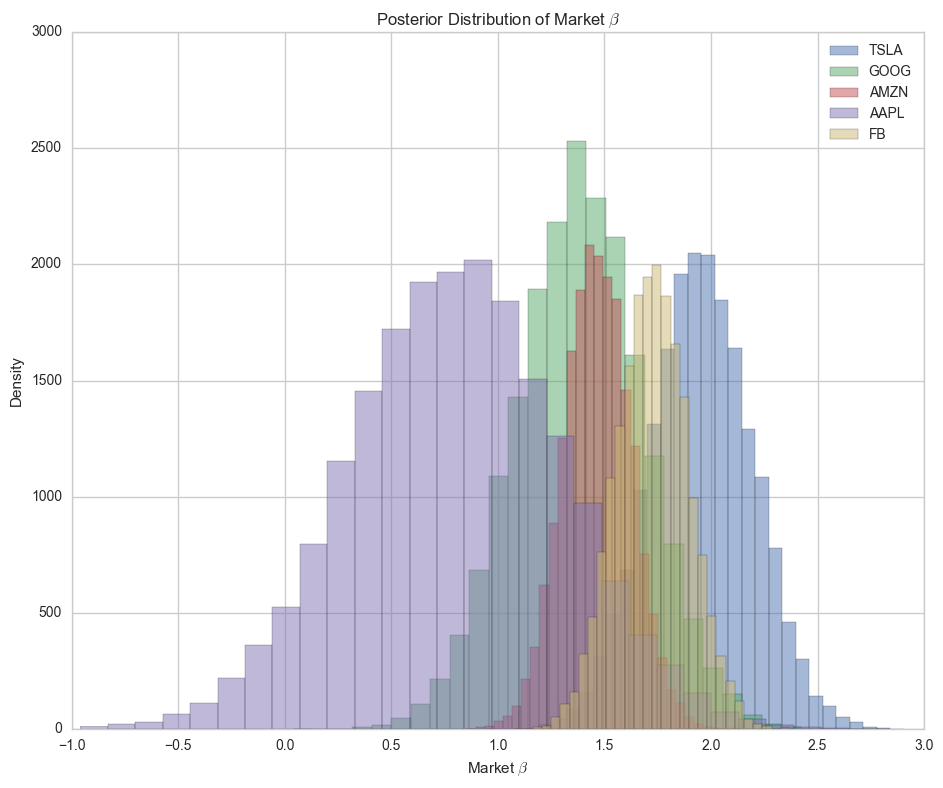

In [25]:
plt.figure(figsize=(11,9))
for symbol in indiv_traces:
    plt.hist(indiv_traces[symbol][100:]['beta'], bins=30, alpha = 0.50, label=symbol)
plt.title(r'Posterior Distribution of Market $\beta$')
plt.xlabel(r'Market $\beta$')
plt.ylabel('Density')
plt.legend()
plt.show();

These are all separate estimates of market beta. They are perfectly valid estimates, but they are not linked upstream ignore this intimate economic link between everything in the market that we have been discussing.

## Making Regression Hierarchical

We have only fetched returns data for technology stocks in this example. Because these all live within the same industry, it is reasonable to think that there is some fundamental relationship that ties all of them together. As such, we should be able to express this with our model. This is just one example of a potential hierarchical relationship when handling data. Many situations may be advantaged by adding structure like this.

In the previous example, we modeled each individual stock with a different beta. We could instead model them all with the same beta, but this does not necessarily make sense. The beta values we already have indicate that there are some differences in how each stock is affected by the market and that to paint everything with the same brush would be ridiculous. To add hierarchical structure, we will instead connect the priors of those market betas by having them be drawn from the same distribution.

We construct a core beta and a core alpha parameter, as before, but we allow their parameters to vary. We then give each individual stock an offset from these core parameters, linking them at their hearts and allowing them to vary around the centers. The resulting model will look like this:

![Hierarchical Regression](hierarchical_regression.png)

We express this in PyMC3 code like so:

In [26]:
with pm.Model() as hierarchical:
    # Hyperpriors - These connect the core beta and alpha values of each security
    mu_a = pm.Normal('mu_alpha', mu=0, sd=10)
    sigma_a = pm.HalfCauchy('sigma_alpha', beta=10)
    mu_b = pm.Normal('mu_beta', mu=1, sd=10)
    sigma_b = pm.HalfCauchy('sigma_beta', beta=10)
    
    # Individual priors for each security, all linked by the hyperpriors
    a_offset = pm.Normal('a_offset', mu=0, sd=1, shape=n_securities)
    alpha = pm.Deterministic("alpha", mu_a + a_offset*sigma_a)
    b_offset = pm.Normal('b_offset', mu=0, sd=1, shape=n_securities)
    beta = pm.Deterministic('beta', mu_b + b_offset*sigma_b)
    
    # Error
    e = pm.HalfCauchy('e', 5)
    
    # Data likelihood
    exposure_likelihood = pm.Normal(
        'exposure_likelihood',
        mu=alpha[stock_idx] + beta[stock_idx]*returns.SPY.values,
        sd=e,
        observed=returns.Returns.values
    )

In [27]:
with hierarchical:
    hierarchical_trace = pm.sample(5000, njobs=4, tune=500)[500:]

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = 2,446: 100%|██████████| 200000/200000 [00:31<00:00, 6333.25it/s]  
Finished [100%]: Average ELBO = 2,446.1
100%|██████████| 5000/5000 [01:33<00:00, 53.22it/s] 


And now our Gelman-Rubin diagnostics:

In [28]:
print('Diagnostics for our hierarchical model:\n', pm.diagnostics.gelman_rubin(hierarchical_trace))

Diagnostics for our hierarchical model:
 {'sigma_alpha_log_': 1.0004456876763494, 'beta': array([ 1.00016146,  1.00002309,  1.00019108,  0.99992573,  1.00009638]), 'sigma_beta_log_': 1.0012867688929361, 'b_offset': array([ 1.00008514,  0.99993073,  1.00011006,  0.99990823,  0.99995695]), 'mu_beta': 1.0003149155698396, 'sigma_alpha': 1.0002229935321305, 'e_log_': 0.9999148798298817, 'sigma_beta': 1.0000076389573045, 'alpha': array([ 1.0000827 ,  1.00016021,  0.99999634,  0.99998219,  1.0000094 ]), 'mu_alpha': 1.0003931009537839, 'e': 0.99991465101163091, 'a_offset': array([ 0.99997144,  1.00035843,  0.99991352,  0.99994191,  1.00027519])}


From observing our Gelman-Rubin diagnostics, we can see that all of our parameters again have converged. We can also look at the traceplot below to see this:

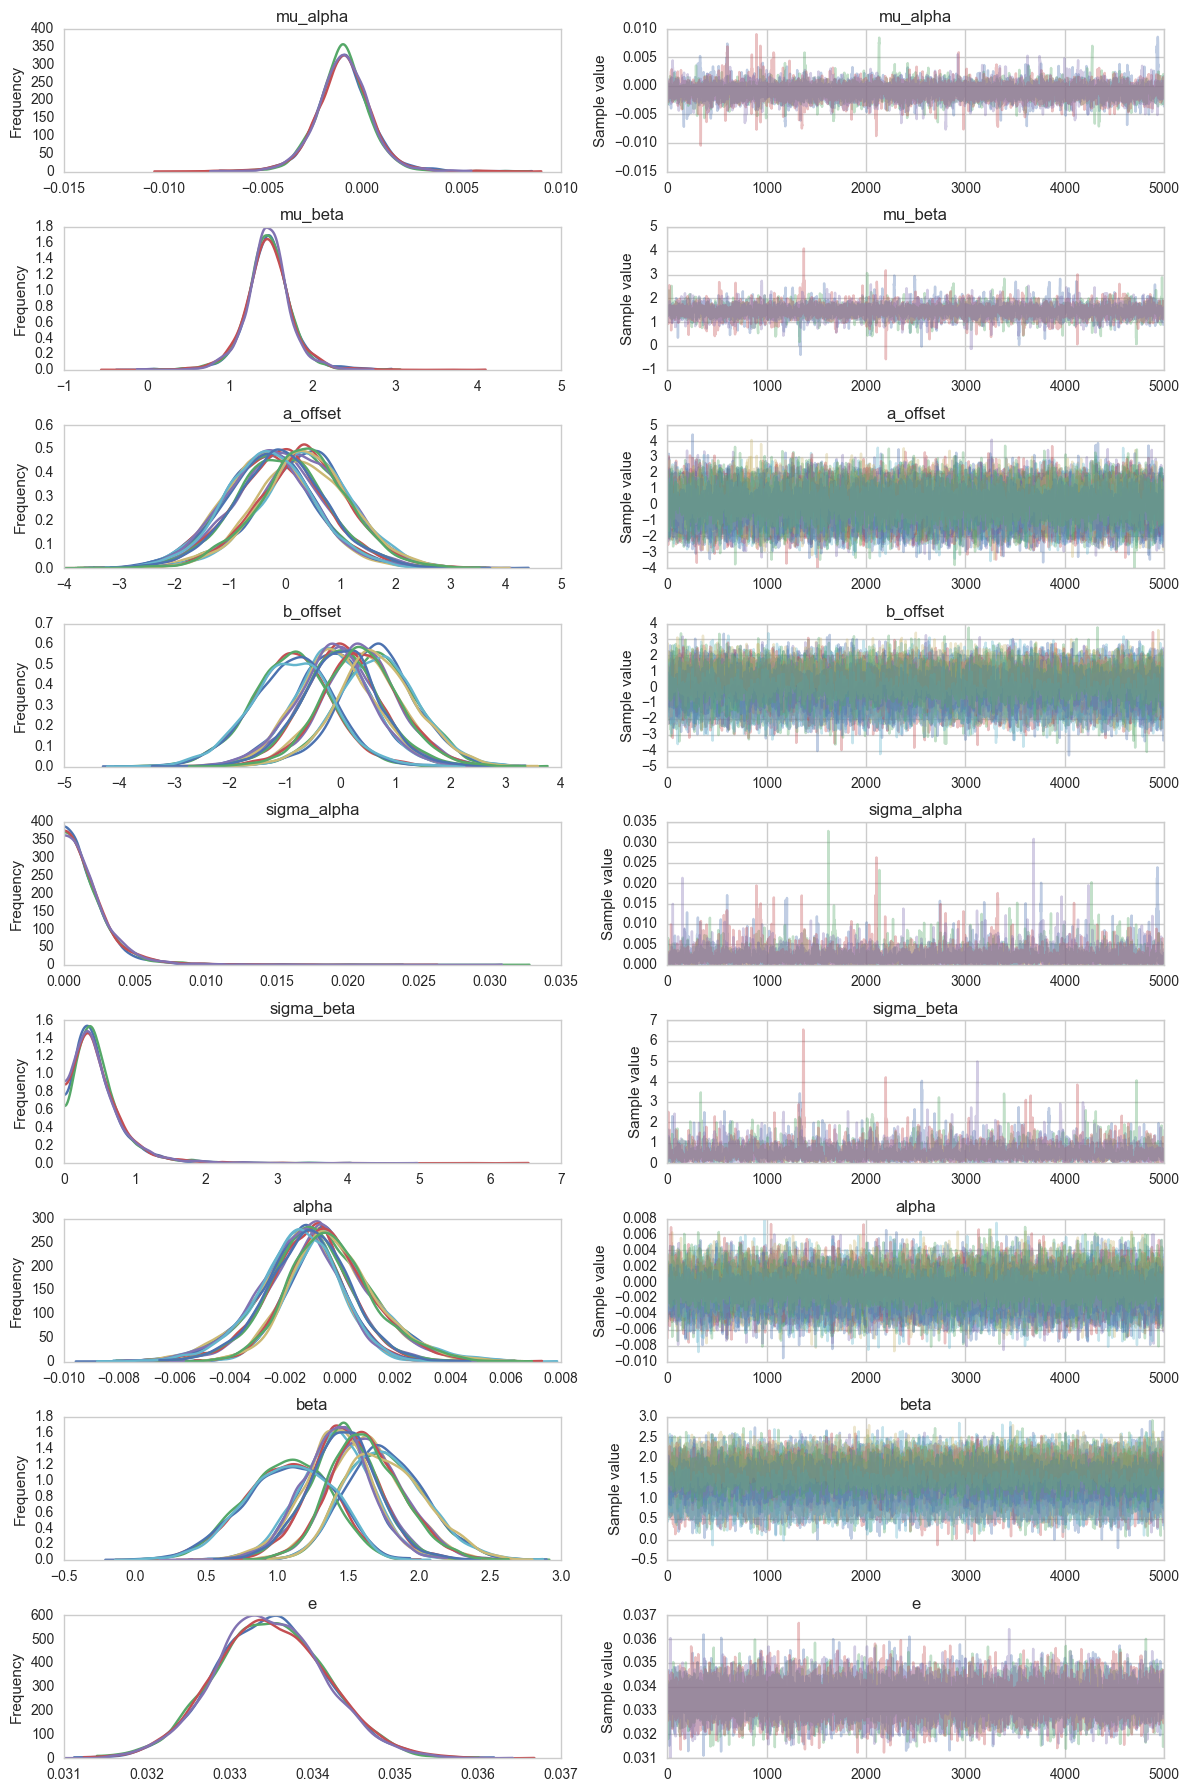

In [29]:
pm.traceplot(hierarchical_trace)
plt.show();

The intercept terms for our linear regressions, $\lbrace\alpha_i\rbrace_{i=0}^{n=4}$, are all given a normal distribution whose parameters are shown above on the graphs for `mu_a` and `sigma_a`. Similarly, our set of betas are all normally distributed with their parameters given by `mu_b` and `sigma_b`. We do not have any strange patterns in the traces of any of our parameters, so it looks like everything is all set.

So now let's have a look at our posterior distributions for our market betas!

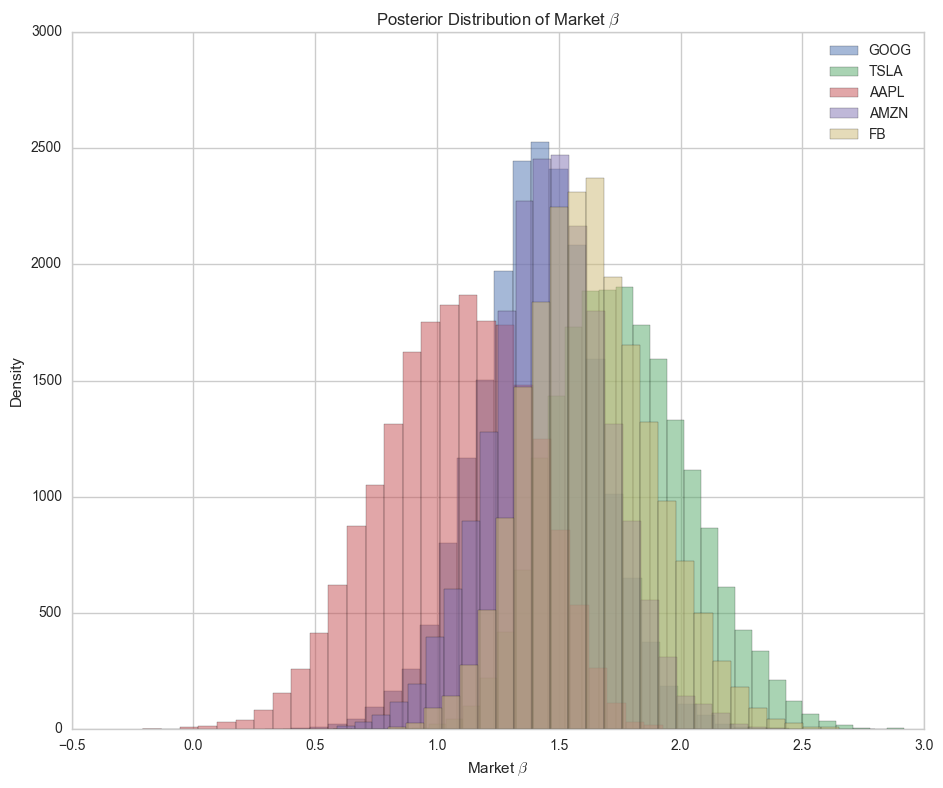

In [30]:
plt.figure(figsize=(11,9))
for idx, symbol in enumerate(stocks):
    plt.hist(hierarchical_trace['beta'][:,idx], bins=30, alpha=0.50, label=symbol)
plt.title(r'Posterior Distribution of Market $\beta$')
plt.xlabel(r'Market $\beta$')
plt.ylabel('Density')
plt.legend()
plt.show();

It looks like connecting our betas at the top brought their posterior distributions much closer together. This makes sense due to their formulation as everything was varying around a common core. The answer to whether this is a strictly better calculation of our market risk exposure than calculating non-hierarchical market betas is up in the air, but this certainly makes sense from an economic standpoint.

## Summary

Adapting our traditional statistical models to Bayesian frameworks can result in a good intuitive understanding of our results. By quantifying our uncertainty as probabilities, Bayesian methods can more clearly reflect how we look at models and the assumptions that underlie them. PyMC3 allows us to define probabilistic models simply, providing easy definitions of classic GLMs.

## Citations TODO

[1] http://twiecki.github.io/blog/2013/08/12/bayesian-glms-1/

[2] https://pymc-devs.github.io/pymc3/notebooks/GLM-logistic.html

[3] Yeh, I. C., & Lien, C. H. (2009). The comparisons of data mining techniques for the predictive accuracy of probability of default of credit card clients. Expert Systems with Applications, 36(2), 2473-2480.

[4] http://twiecki.github.io/blog/2014/03/17/bayesian-glms-3/